<a href="https://colab.research.google.com/github/anvesh-lp/BruteForce/blob/main/DataOptimizationAMAZON_usingRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd #Data manipulation and analysis
import numpy as np #Numerical computing
import matplotlib.pyplot as plt #Data Visualzation
import seaborn as sns #Data Visualzation
import time #Various time-related functions

In [2]:
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 24.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
#Settings for appropriate display  

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [63]:
#Ignoring all warning ⚠ messages thrown

import warnings
warnings.filterwarnings('ignore')

In [80]:
import pandas_datareader as pdr #Remote data access for pandas
from datetime import date

df = pdr.DataReader('AMZN', data_source='yahoo', start='2016-01-01', end = "2021-12-31")
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,32.886002,31.375500,32.814499,31.849501,186290000,31.849501
2016-01-05,32.345501,31.382500,32.342999,31.689501,116452000,31.689501
2016-01-06,31.989500,31.015499,31.100000,31.632500,106584000,31.632500
2016-01-07,31.500000,30.260500,31.090000,30.396999,141498000,30.396999
2016-01-08,31.207001,30.299999,30.983000,30.352501,110258000,30.352501


In [81]:
df = df["Close"]
df = pd.DataFrame(df)
df.head()

,Close
Date,
2016-01-04,31.849501
2016-01-05,31.689501
2016-01-06,31.632500
2016-01-07,30.396999
2016-01-08,30.352501


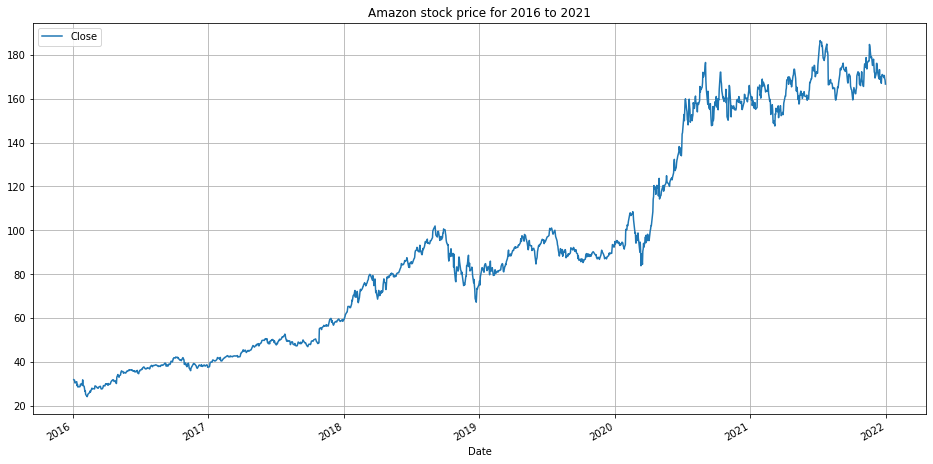

In [82]:
df.plot(figsize=(16,8), title = "Amazon stock price for 2016 to 2021", grid = True)

In [83]:
%matplotlib inline
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [84]:
data = df

In [93]:
train_data = data[2:900] 
test_data = data[900:] 
train = train_data.values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

In [102]:
from numpy.random import seed
seed(2019)

model = Sequential()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

In [103]:
# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
%time model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
28/28 [==============================] - 7s 17ms/step - loss: 0.0916
Epoch 2/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0122
Epoch 3/40
28/28 [==============================] - 0s 17ms/step - loss: 0.0069
Epoch 4/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0063
Epoch 5/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0058
Epoch 6/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0058
Epoch 7/40
28/28 [==============================] - 0s 17ms/step - loss: 0.0043
Epoch 8/40
28/28 [==============================] - 0s 18ms/step - loss: 0.0055
Epoch 9/40
28/28 [==============================] - 0s 17ms/step - loss: 0.0047
Epoch 10/40
28/28 [==============================] - 0s 17ms/step - loss: 0.0048
Epoch 11/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0037
Epoch 12/40
28/28 [==============================] - 0s 17ms/step - loss: 0.0038
Epoch 13/40
28/28 [==================

In [104]:
# this will be used later while comparing and visualization

real_stock_price = test_data.iloc[:,0:1].values # taking open price

In [105]:
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Close'], test_data['Close']), axis = 0)

# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [106]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

20/20 [==============================] - 2s 5ms/step


In [107]:
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean Square Error (MSE): '+str(mean_squared_error(real_stock_price, predicted_stock_price)))
print('Mean Absolute Error(MAE): '+str(mean_absolute_error(real_stock_price, predicted_stock_price)))
print('Root Mean Square Error (RMSE): '+str(math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))))

Mean Square Error (MSE): 1607.5673979109536
Mean Absolute Error(MAE): 33.26544049601703
Root Mean Square Error (RMSE): 40.094480890902595


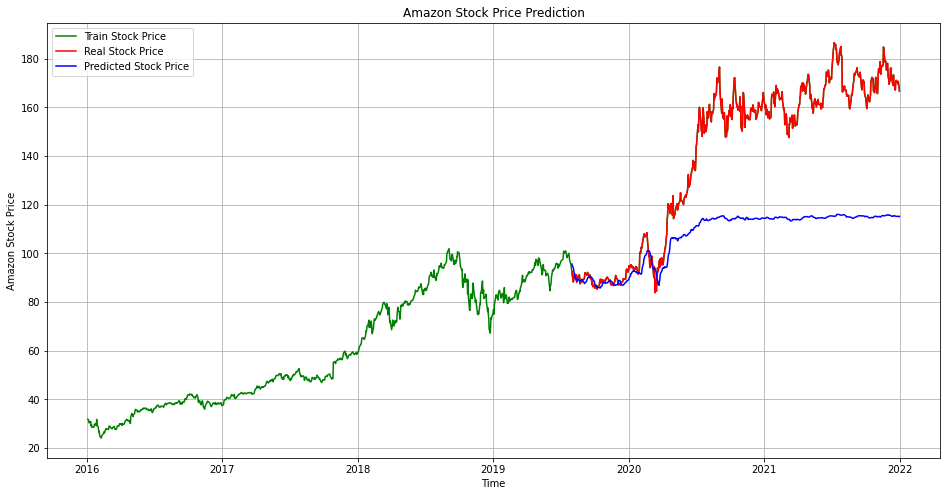

In [108]:
#Visualize entire data

plt.figure(figsize=(16,8))
plt.plot(data.index, data['Close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.grid(True)
plt.show()

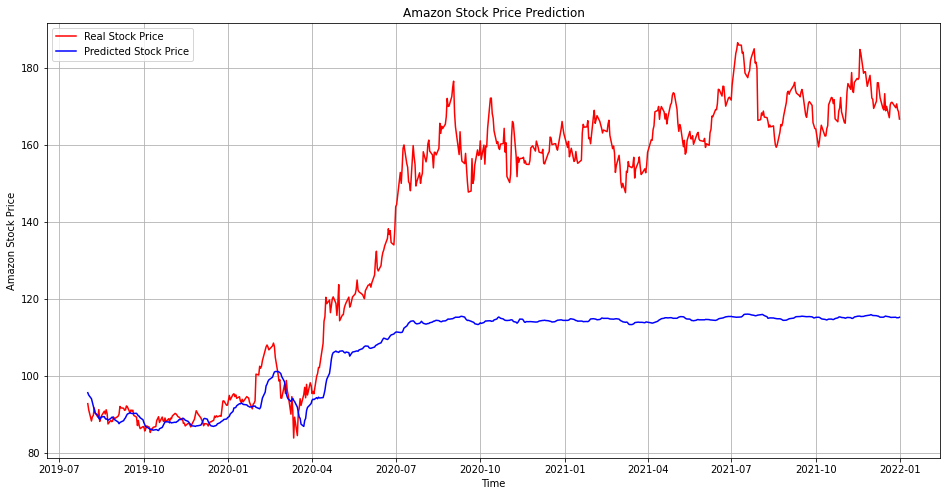

In [109]:
#Visualize the test data

plt.figure(figsize=(16,8))
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.grid(True)
plt.show()